<a href="https://colab.research.google.com/github/yagel2/TDS_NYC_Airbnb/blob/main/TDS_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TDS Final Project: Automated Feature Selection for Improving Predictive Model Robustness**
---
### **Authors:** Yagel Alankry & Ido Keren

# Tabular Data Science Final Project
## Automated Feature Selection for Improving Predictive Model Robustness

### **Objective**
This project aims to improve predictive modeling by implementing automated feature selection techniques. We compare different methods like SHAP-based ranking, Recursive Feature Elimination (RFE), and Permutation Importance to determine which selection approach improves model performance.
Feature selection is extremely important- choosing the wrong features could lead to overfitting, low efficiency and low interpretability.

Our general approach would be to try to find the features to learn where our model would have a good r^2 rating.

### **Datasets**
We use multiple datasets from Kaggle, including:
1. Salary Data
2. Sleep Efficiency
3. Bestsellers with categories
4. Global Air Pollution Dataset
5. Our origin data - Airbnb NYC

### **Methods**
- Exploratory Data Analysis (EDA)
- Feature Selection:
  - SHAP Feature Importance
  - Recursive Feature Elimination (RFE)
  - Permutation Importance
- Model Training & Evaluation
- Comparison of Performance Metrics

Imports and load data

In [188]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

!wget --no-clobber https://raw.githubusercontent.com/yagel2/TDS_NYC_Airbnb/main/AB_NYC_2019.csv
!wget --no-clobber https://raw.githubusercontent.com/yagel2/TDS_NYC_Airbnb/main/'bestsellers with categories'.csv
!wget --no-clobber https://raw.githubusercontent.com/yagel2/TDS_NYC_Airbnb/main/'global air pollution dataset'.csv
!wget --no-clobber https://raw.githubusercontent.com/yagel2/TDS_NYC_Airbnb/main/Sleep_Efficiency.csv
!wget --no-clobber https://raw.githubusercontent.com/yagel2/TDS_NYC_Airbnb/main/'Salary Data'.csv


File ‘AB_NYC_2019.csv’ already there; not retrieving.

File ‘bestsellers with categories.csv’ already there; not retrieving.

File ‘global air pollution dataset.csv’ already there; not retrieving.

File ‘Sleep_Efficiency.csv’ already there; not retrieving.

File ‘Salary Data.csv’ already there; not retrieving.



### **Part 1: Explaining Our Solution**

Feature selection is extremely important- choosing the wrong features could lead to overfitting, low efficiency and low interpretability.

In our final project we wish to automate that as feature selection can be often confusing and tedious.

Our general approach would be to try to find the features to learn where our model would have a good r^2 rating.

We will go over the Automated process with the dataset of airbnb's in new york city, and find the best features to learn to predict the price.

In [189]:
df = pd.read_csv('AB_NYC_2019.csv')

# Load data
data = df.copy()

# Fill empty values of reviews per month with 0
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

# Drop rows with missing values in the 'price' column
data = data.dropna(subset=['price'])

# One-hot encoding
data = pd.get_dummies(data, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Set target feature to price, and the features to learn it every numeric or boolean feature in the dataset
y = data['price']
X = data.select_dtypes(include=['number', 'bool']).drop(columns=['price'])

We wish to compare our automated feature selection to a naive solution, which would be to use all of the features.

In [190]:
# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_naive = y_pred

# Naive model metrics
mae_naive = mean_absolute_error(y_test, y_pred)
mse_naive = mean_squared_error(y_test, y_pred)
r2_naive = r2_score(y_test, y_pred)
pearson_naive, _ = pearsonr(y_test, y_pred)

# Print metrics comparison as a table
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R²', 'Pearson'],
    'Naive Solution': [mae_naive, mse_naive, r2_naive, pearson_naive]
})

print(metrics_comparison)

    Metric  Naive Solution
0      MAE       67.251572
1      MSE    45058.171875
2       R²       -0.018534
3  Pearson        0.371187


The r^2 score is negative, meaning a better prediction would be to return for everyone the average. this happends due to overfitting.

First, to improve interpretability we will look at every feature and its collinearity with the target feature. under a certain threshold of conllinearity we remove that feature.

In [191]:
def remove_low_correlated_features(X, y, corr_threshold=0.05):
  """
  Removes features that are not collerated with the target feature.
  """

  correlations = X.corrwith(y)
  important_corr_features = correlations[abs(correlations) > corr_threshold].index.tolist()
  new_X = X[important_corr_features]

  return new_X

In [192]:
print(f"Features before correlation to target filter: {len(X.columns)}")
X = remove_low_correlated_features(X, y, corr_threshold=0.05)
print(f"Features after correlation to target filter: {len(X.columns)}")

Features before correlation to target filter: 15
Features after correlation to target filter: 9


Next, we would like to remove features that are too similar to one another. if two feature are similar the one that will be kept is the one that is more collinear to the target feature.

In [193]:
def remove_highly_correlated_features(X, y, corr_threshold=0.85):
    """
    Removes one of each pair of features with high correlation.
    Keeps the feature that is more correlated with the target.
    """
    # Absolute correlation matrix
    corr_matrix = X.corr().abs()

    # Correlation of each feature with target
    target_corr = X.corrwith(y).abs()

    # Set of columns to remove
    to_remove = set()

    # Iterate through correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            feature_1 = corr_matrix.columns[i]
            feature_2 = corr_matrix.columns[j]

            # Check if the pair is highly correlated
            if corr_matrix.iloc[i, j] > corr_threshold:
                # Compare correlation with target
                if target_corr[feature_1] < target_corr[feature_2]:
                    to_remove.add(feature_1)
                else:
                    to_remove.add(feature_2)

    # Drop less relevant correlated features
    X_filtered = X.drop(columns=list(to_remove))

    return X_filtered

In [194]:
X = remove_highly_correlated_features(X, y, corr_threshold=0.85)
print(f"Features left after removing highly correlated pairs: {len(X.columns)}")

Features left after removing highly correlated pairs: 9


Now for the remaining features, we wish to rank them by importance. We train a XGBRegressor on the remaining feature, then calculate the features SHAP importance in the model and sort by most important.

In [195]:
def calculate_feature_importance(X, y):
  """
  Calculates for each feature its importance in the XGBRegressor.
  """

  # train-test split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and train XGBRegressor
  xgb_model = XGBRegressor()
  xgb_model.fit(X_train, y_train)

  # Predictions (optional, if you need them)
  y_pred_test = xgb_model.predict(X_test)
  y_pred_train = xgb_model.predict(X_train)

  # SHAP analysis using the trained regressor
  explainer = shap.TreeExplainer(xgb_model)
  shap_values = explainer.shap_values(X_train)

  shap.summary_plot(shap_values, X_train)


  # Aggregate SHAP values
  shap_importance = np.abs(shap_values).mean(axis=0)

  # Rank features by SHAP importance
  shap_importance_df = pd.DataFrame({
      'feature': X_train.columns,
      'importance': shap_importance
  }).sort_values(by='importance', ascending=False)

  return shap_importance_df

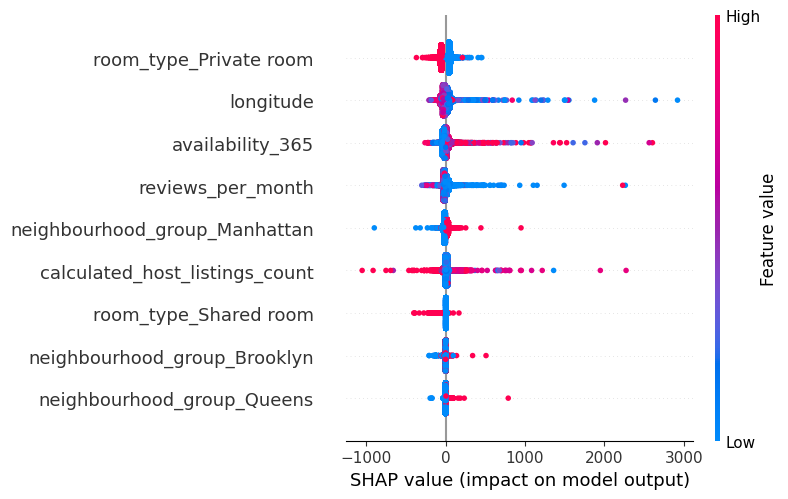

                          feature  importance
7          room_type_Private room   53.217731
0                       longitude   30.421877
3                availability_365   26.885677
1               reviews_per_month   19.281372
5   neighbourhood_group_Manhattan   15.115685
2  calculated_host_listings_count    9.147669
8           room_type_Shared room    5.523805
4    neighbourhood_group_Brooklyn    1.987292
6      neighbourhood_group_Queens    1.696134


In [196]:
shap_importance_df = calculate_feature_importance(X, y)
print(shap_importance_df)

Finally, we will iteratively add another feature (the next most important one) to the XGBRegressor model, then check the r^2 value. when the r^2 value starts to go down we stop as the model starts to overfit.

In [197]:
def calculate_best_features(X, y, shap_importance_df):
  """
  Calculates the features to select.
  """

  # Store the best r^2 we got in this variable(init to -1 as we got no r^2 yet)
  best_r2 = -1

  for top_k in range(1, len(shap_importance_df) + 1):
    selected_features = shap_importance_df['feature'].iloc[:top_k].tolist()

    # Final dataset
    X_final = X[selected_features]

    # train-test split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

    # Retrain final model on training set
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred = xgb_model.predict(X_test)

    # Evaluate r^2 metric
    r2 = r2_score(y_test, y_pred)

    # If model did better, update he value of the best r^2 we got.
    if r2 > best_r2:
      best_r2 = r2

    # If model did worse, return the features without the last one.
    else:
      return selected_features[:-1]
  return selected_features

In [198]:
selected_features = calculate_best_features(X, y, shap_importance_df)
print(f"The features selected: {selected_features}")

The features selected: ['room_type_Private room', 'longitude']


Lets use those feature to predict the price.

In [199]:
# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Selected features model metrics
mae_new = mean_absolute_error(y_test, y_pred)
mse_new = mean_squared_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)
pearson_new, _ = pearsonr(y_test, y_pred)

# Print metrics comparison as a table
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R²', 'Pearson'],
    'Naive Solution': [mae_naive, mse_naive, r2_naive, pearson_naive],
    'Automated Solution': [mae_new, mse_new, r2_new, pearson_new]
})

print(metrics_comparison)

    Metric  Naive Solution  Automated Solution
0      MAE       67.251572           71.160538
1      MSE    45058.171875        40056.316406
2       R²       -0.018534            0.094532
3  Pearson        0.371187            0.310583


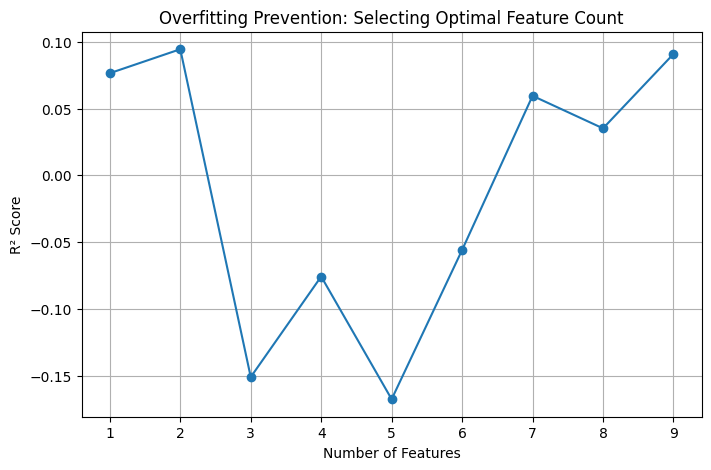

<Figure size 640x480 with 0 Axes>

In [200]:
r2_scores = []
feature_counts = list(range(1, len(shap_importance_df)+1))

for top_k in feature_counts:
    selected_features = shap_importance_df['feature'].iloc[:top_k].tolist()
    X_selected = X[selected_features]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

    # Train Model
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred = xgb_model.predict(X_test)

    # Evaluate R² Score
    r2_scores.append(r2_score(y_test, y_pred))

# Plot the R² scores against the number of features used
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, r2_scores, marker='o', linestyle='-')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('Overfitting Prevention: Selecting Optimal Feature Count')
plt.grid()
plt.show()

We got a clear improvement from the naive solution in the r^2 metric, while also having significantly faster computation time.

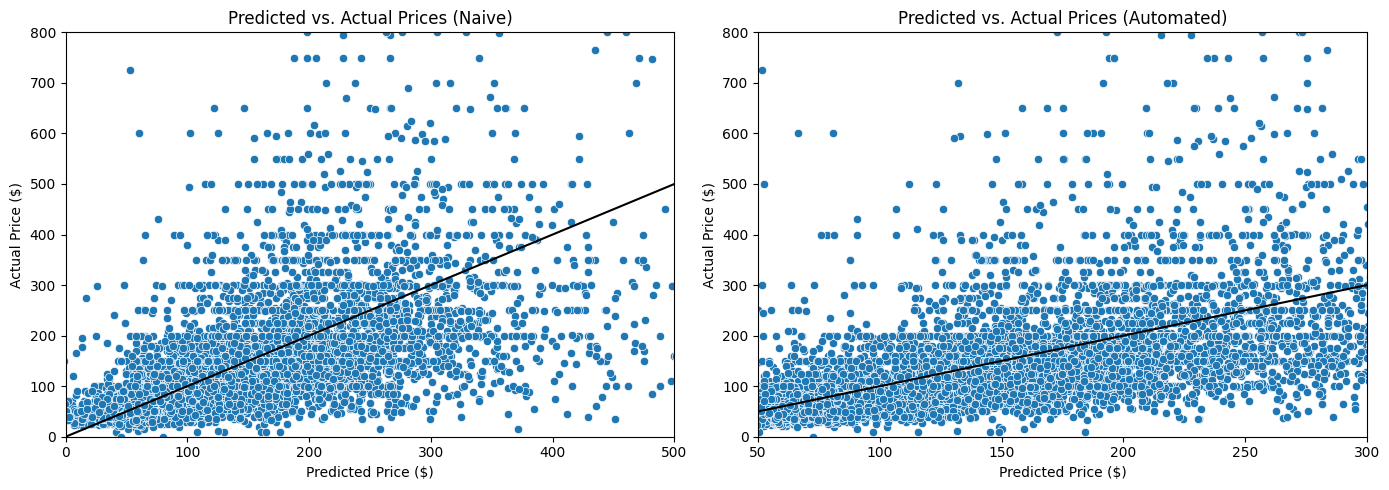

In [201]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First plot (Naive Model)
sns.scatterplot(x=y_pred_naive, y=y_test, ax=axes[0])
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Actual Price ($)')
axes[0].set_ylim(0, 800)
axes[0].set_xlim(0, 500)
axes[0].set_title('Predicted vs. Actual Prices (Naive)')
sns.lineplot(x=y_pred_naive, y=y_pred_naive, ax=axes[0], color='black')

# Second plot (Automated Model)
sns.scatterplot(x=y_pred, y=y_test, ax=axes[1])
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Actual Price ($)')
axes[1].set_ylim(0, 800)
axes[1].set_xlim(50, 300)
axes[1].set_title('Predicted vs. Actual Prices (Automated)')
sns.lineplot(x=y_pred, y=y_pred, ax=axes[1], color='black')

# Show both plots together
plt.tight_layout()
plt.show()

This is our process, the final function would look like this.

In [202]:
def select_features(X, y):
  """
  Returns the features to select.
  """
  X = remove_low_correlated_features(X, y, corr_threshold=0.05)
  X = remove_highly_correlated_features(X, y, corr_threshold=0.85)
  shap_importance_df = calculate_feature_importance(X, y)
  selected_features = calculate_best_features(X, y, shap_importance_df)
  return selected_features

### **Part 2: Present Our Solution on Different Datasets**

The fisrt dataset is a dataset about Amazon's bestselling books, and our goal would be to predict the Rating of the book given by users.

In [203]:
df = pd.read_csv('bestsellers with categories.csv')

data = df.copy()

# One-hot encoding
data = pd.get_dummies(data, columns=['Genre', ], drop_first=True)


X = data.select_dtypes(include=['number', 'bool']).drop(columns=['User Rating'])
print(f"Features before correlation to target filter: {len(X.columns)}")
y = data['User Rating']

Features before correlation to target filter: 4


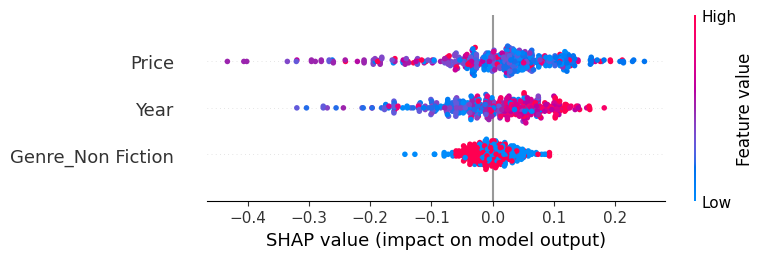

The features selected: ['Price']


In [204]:
selected_features = select_features(X, y)
print(f"The features selected: {selected_features}")

In [205]:
# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_naive = y_pred

# Naive model metrics
mae_naive = mean_absolute_error(y_test, y_pred)
mse_naive = mean_squared_error(y_test, y_pred)
r2_naive = r2_score(y_test, y_pred)
pearson_naive, _ = pearsonr(y_test, y_pred)

# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Selected features model metrics
mae_new = mean_absolute_error(y_test, y_pred)
mse_new = mean_squared_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)
pearson_new, _ = pearsonr(y_test, y_pred)

# Print metrics comparison as a table
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R²', 'Pearson'],
    'Naive Solution': [mae_naive, mse_naive, r2_naive, pearson_naive],
    'Automated Solution': [mae_new, mse_new, r2_new, pearson_new]
})

print(metrics_comparison)

    Metric  Naive Solution  Automated Solution
0      MAE        0.138993            0.158052
1      MSE        0.050332            0.047388
2       R²        0.122706            0.174018
3  Pearson        0.439364            0.434407


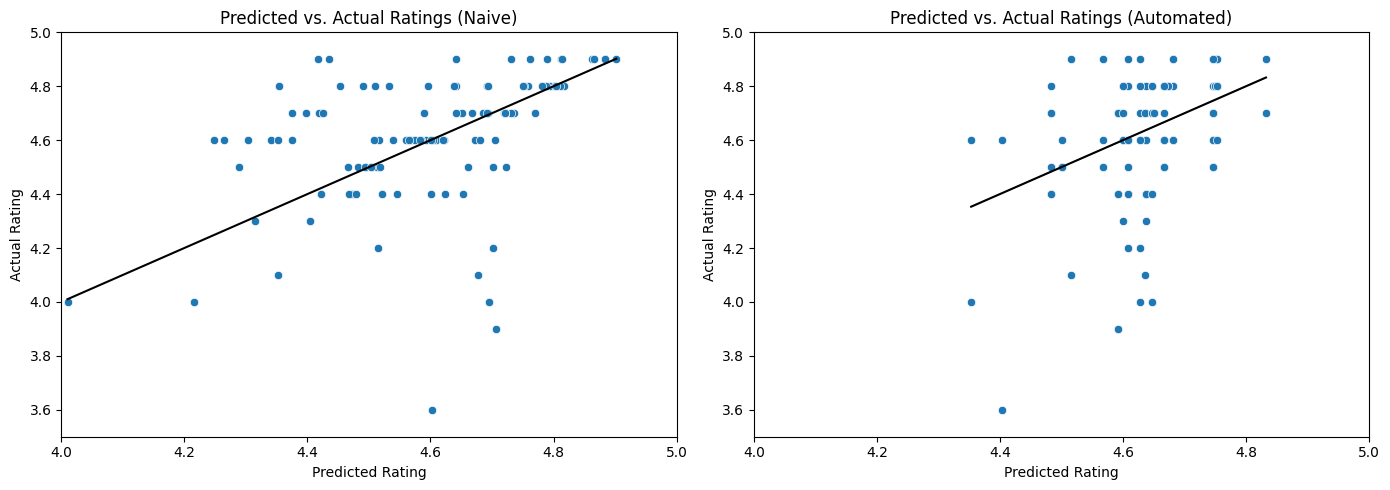

In [206]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First plot (Naive Model)
sns.scatterplot(x=y_pred_naive, y=y_test, ax=axes[0])
axes[0].set_xlabel('Predicted Rating')
axes[0].set_ylabel('Actual Rating')
axes[0].set_ylim(3.5, 5)
axes[0].set_xlim(4, 5)
axes[0].set_title('Predicted vs. Actual Ratings (Naive)')
sns.lineplot(x=y_pred_naive, y=y_pred_naive, ax=axes[0], color='black')

# Second plot (Automated Model)
sns.scatterplot(x=y_pred, y=y_test, ax=axes[1])
axes[1].set_xlabel('Predicted Rating')
axes[1].set_ylabel('Actual Rating')
axes[1].set_ylim(3.5, 5)
axes[1].set_xlim(4, 5)
axes[1].set_title('Predicted vs. Actual Ratings (Automated)')
sns.lineplot(x=y_pred, y=y_pred, ax=axes[1], color='black')

# Show both plots together
plt.tight_layout()
plt.show()

The next dataset is a dataset about global air pollition, and our goal would be to predict the air quality value.

In [207]:
df = pd.read_csv('global air pollution dataset.csv')

data = df.copy()

# One-hot encoding
data = pd.get_dummies(data, columns=['Country'], drop_first=True)
data = data.fillna(0)

X = data.select_dtypes(include=['number', 'bool']).drop(columns=['AQI Value', 'PM2.5 AQI Value'])
print(f"Features before correlation to target filter: {len(X.columns)}")
y = data['AQI Value']

Features before correlation to target filter: 177


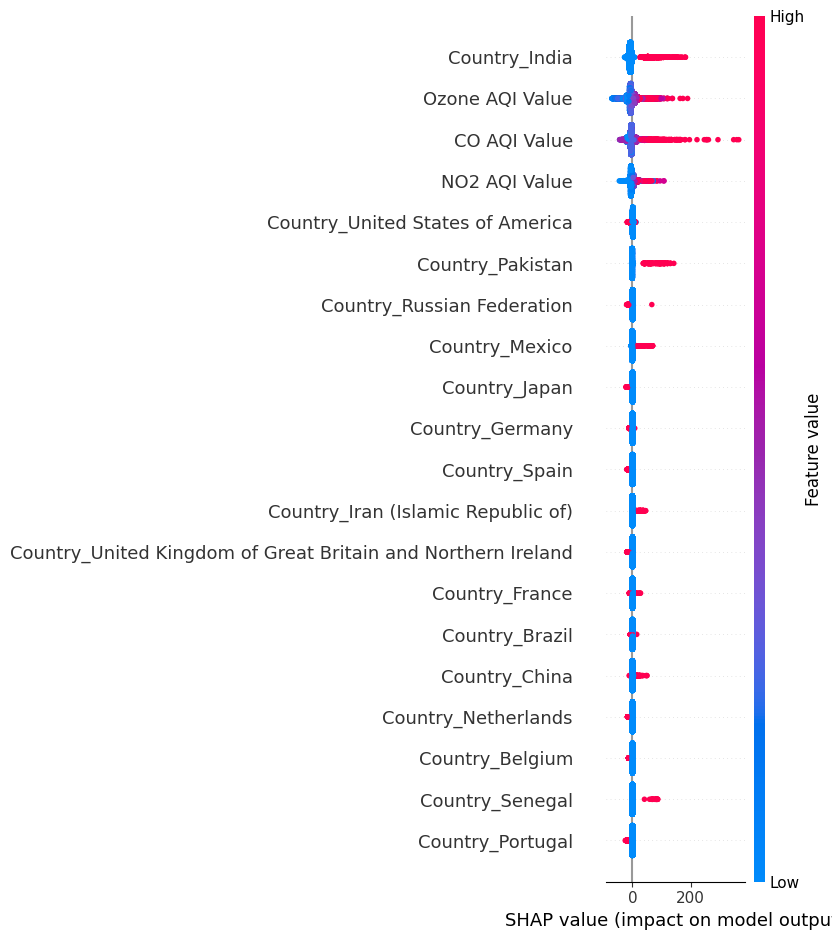

The features selected: ['Country_India', 'Ozone AQI Value', 'CO AQI Value', 'NO2 AQI Value', 'Country_United States of America', 'Country_Pakistan', 'Country_Russian Federation', 'Country_Mexico', 'Country_Japan']


In [208]:
selected_features = select_features(X, y)
print(f"The features selected: {selected_features}")

In [209]:
# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_naive = y_pred

# Naive model metrics
mae_naive = mean_absolute_error(y_test, y_pred)
mse_naive = mean_squared_error(y_test, y_pred)
r2_naive = r2_score(y_test, y_pred)
pearson_naive, _ = pearsonr(y_test, y_pred)

# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Selected features model metrics
mae_new = mean_absolute_error(y_test, y_pred)
mse_new = mean_squared_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)
pearson_new, _ = pearsonr(y_test, y_pred)

# Print metrics comparison as a table
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R²', 'Pearson'],
    'Naive Solution': [mae_naive, mse_naive, r2_naive, pearson_naive],
    'Automated Solution': [mae_new, mse_new, r2_new, pearson_new]
})

print(metrics_comparison)

    Metric  Naive Solution  Automated Solution
0      MAE       15.014386           16.808226
1      MSE      884.824707          958.768250
2       R²        0.722333            0.699129
3  Pearson        0.849956            0.836156


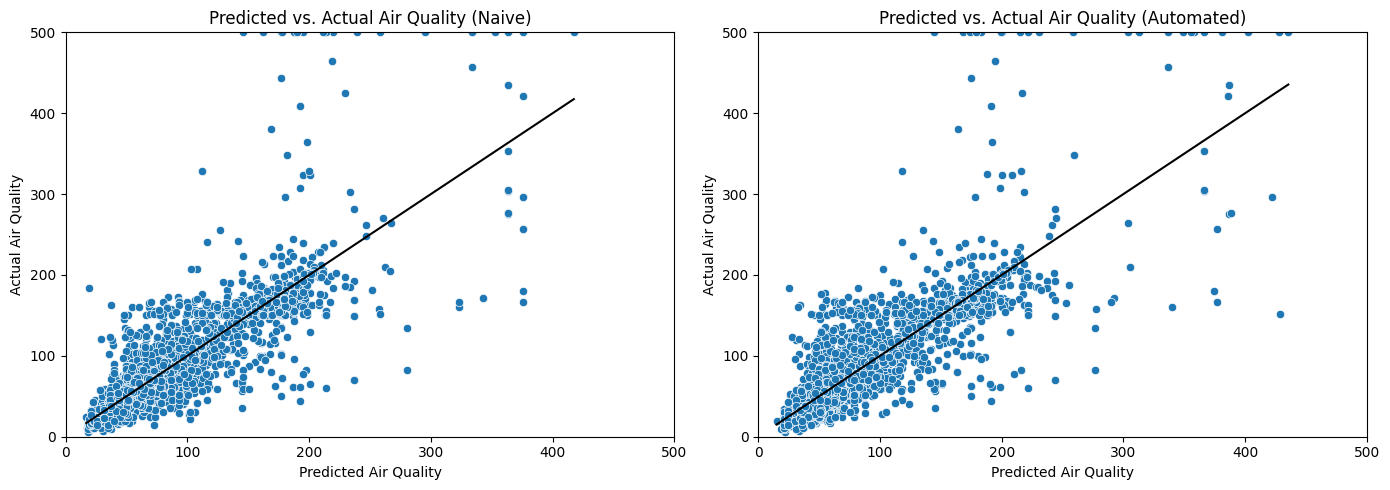

In [210]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First plot (Naive Model)
sns.scatterplot(x=y_pred_naive, y=y_test, ax=axes[0])
axes[0].set_xlabel('Predicted Air Quality')
axes[0].set_ylabel('Actual Air Quality')
axes[0].set_ylim(0, 500)
axes[0].set_xlim(0, 500)
axes[0].set_title('Predicted vs. Actual Air Quality (Naive)')
sns.lineplot(x=y_pred_naive, y=y_pred_naive, ax=axes[0], color='black')

# Second plot (Automated Model)
sns.scatterplot(x=y_pred, y=y_test, ax=axes[1])
axes[1].set_xlabel('Predicted Air Quality')
axes[1].set_ylabel('Actual Air Quality')
axes[1].set_ylim(0, 500)
axes[1].set_xlim(0, 500)
axes[1].set_title('Predicted vs. Actual Air Quality (Automated)')
sns.lineplot(x=y_pred, y=y_pred, ax=axes[1], color='black')

# Show both plots together
plt.tight_layout()
plt.show()

This dataset is about sleep efficiency, showing different data about the sleep itself and other fatcor like if the person is a smoker. our goal in this dataset would be to predict the number of awakenings in a nights sleep.

In [211]:
df = pd.read_csv('Sleep_Efficiency.csv')
data = df.copy()

# One-hot encoding
data = pd.get_dummies(data, columns=['Gender'], drop_first=True)
data = data.fillna(0)

X = data.select_dtypes(include=['number', 'bool']).drop(columns=['Awakenings'])
print(f"Features before correlation to target filter: {len(X.columns)}")
y = data['Awakenings']

Features before correlation to target filter: 11


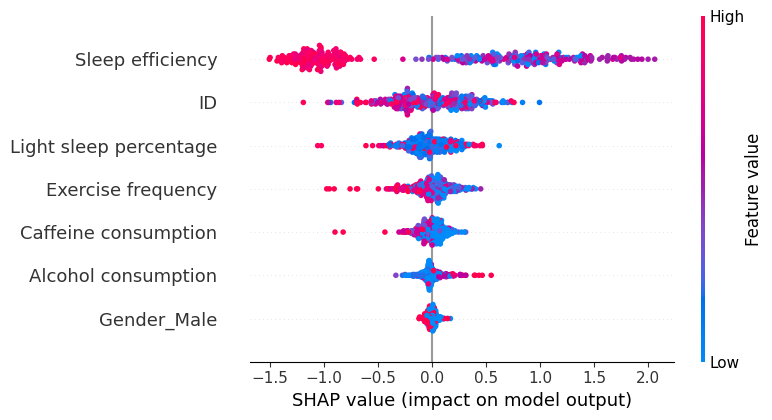

The features selected: ['Sleep efficiency']


In [212]:
selected_features = select_features(X, y)
print(f"The features selected: {selected_features}")

In [213]:
# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_naive = y_pred

# Naive model metrics
mae_naive = mean_absolute_error(y_test, y_pred)
mse_naive = mean_squared_error(y_test, y_pred)
r2_naive = r2_score(y_test, y_pred)
pearson_naive, _ = pearsonr(y_test, y_pred)

# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Selected features model metrics
mae_new = mean_absolute_error(y_test, y_pred)
mse_new = mean_squared_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)
pearson_new, _ = pearsonr(y_test, y_pred)

# Print metrics comparison as a table
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R²', 'Pearson'],
    'Naive Solution': [mae_naive, mse_naive, r2_naive, pearson_naive],
    'Automated Solution': [mae_new, mse_new, r2_new, pearson_new]
})

print(metrics_comparison)

    Metric  Naive Solution  Automated Solution
0      MAE        0.877765            0.866788
1      MSE        1.314584            1.115915
2       R²        0.246117            0.360049
3  Pearson        0.566999            0.631695


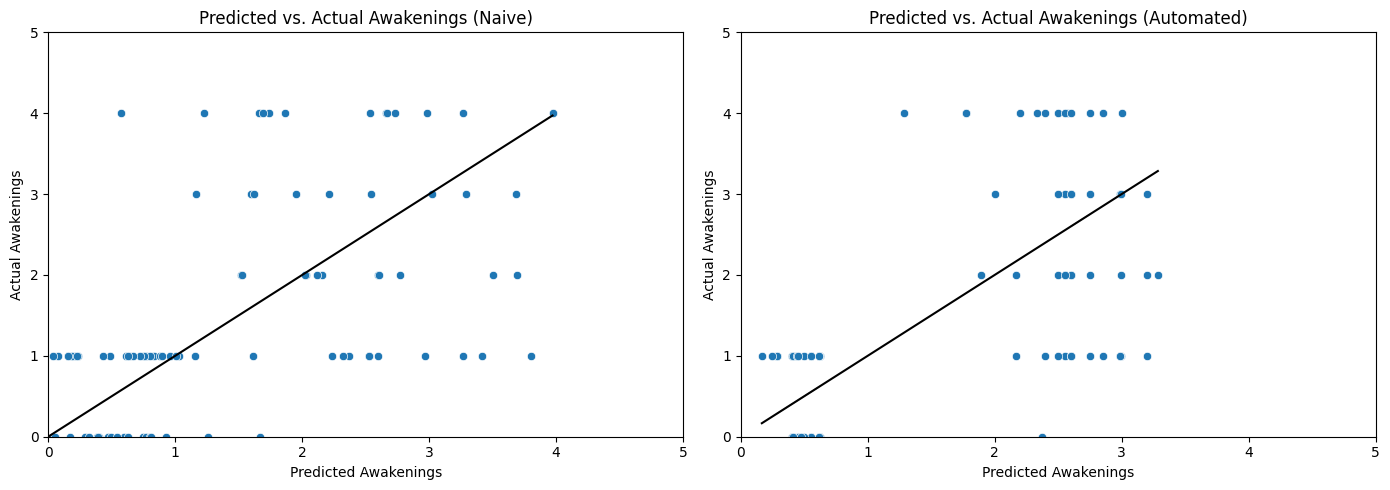

In [214]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First plot (Naive Model)
sns.scatterplot(x=y_pred_naive, y=y_test, ax=axes[0])
axes[0].set_xlabel('Predicted Awakenings')
axes[0].set_ylabel('Actual Awakenings')
axes[0].set_ylim(0, 5)
axes[0].set_xlim(0, 5)
axes[0].set_title('Predicted vs. Actual Awakenings (Naive)')
sns.lineplot(x=y_pred_naive, y=y_pred_naive, ax=axes[0], color='black')

# Second plot (Automated Model)
sns.scatterplot(x=y_pred, y=y_test, ax=axes[1])
axes[1].set_xlabel('Predicted Awakenings')
axes[1].set_ylabel('Actual Awakenings')
axes[1].set_ylim(0, 5)
axes[1].set_xlim(0, 5)
axes[1].set_title('Predicted vs. Actual Awakenings (Automated)')
sns.lineplot(x=y_pred, y=y_pred, ax=axes[1], color='black')

# Show both plots together
plt.tight_layout()
plt.show()

The last dataset is about workers, we will try to predict their salary from their job, age, education level and years of experience.

In [215]:
df = pd.read_csv('Salary Data.csv')
data = df.copy()

# One-hot encoding
data = pd.get_dummies(data, columns=['Education Level', 'Job Title'], drop_first=True)
data = data.fillna(0)

X = data.select_dtypes(include=['number', 'bool']).drop(columns=['Salary'])
print(f"Features before correlation to target filter: {len(X.columns)}")
y = data['Salary']

Features before correlation to target filter: 177


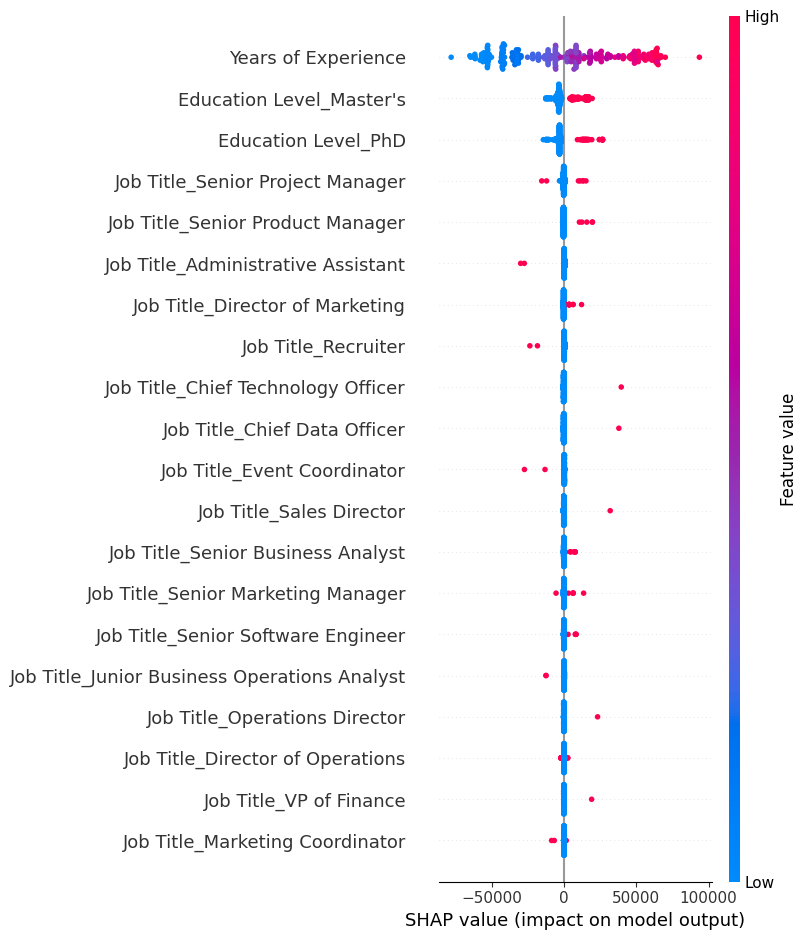

The features selected: ['Years of Experience', "Education Level_Master's"]


In [216]:
selected_features = select_features(X, y)
print(f"The features selected: {selected_features}")

In [217]:
# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)
y_pred_naive = y_pred

# Naive model metrics
mae_naive = mean_absolute_error(y_test, y_pred)
mse_naive = mean_squared_error(y_test, y_pred)
r2_naive = r2_score(y_test, y_pred)
pearson_naive, _ = pearsonr(y_test, y_pred)

# train-test split for evaluation
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Retrain final model on training set
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Selected features model metrics
mae_new = mean_absolute_error(y_test, y_pred)
mse_new = mean_squared_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)
pearson_new, _ = pearsonr(y_test, y_pred)

# Print metrics comparison as a table
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R²', 'Pearson'],
    'Naive Solution': [f"{mae_naive:.2f}", f"{mse_naive:.2f}", f"{r2_naive:.6f}", f"{pearson_naive:.6f}"],
    'Automated Solution': [f"{mae_new:.2f}", f"{mse_new:.2f}", f"{r2_new:.6f}", f"{pearson_new:.6f}"]
})

print(metrics_comparison)

    Metric Naive Solution Automated Solution
0      MAE       10482.01           11723.06
1      MSE   263729609.29       264482466.92
2       R²       0.896899           0.896605
3  Pearson       0.948062           0.949218


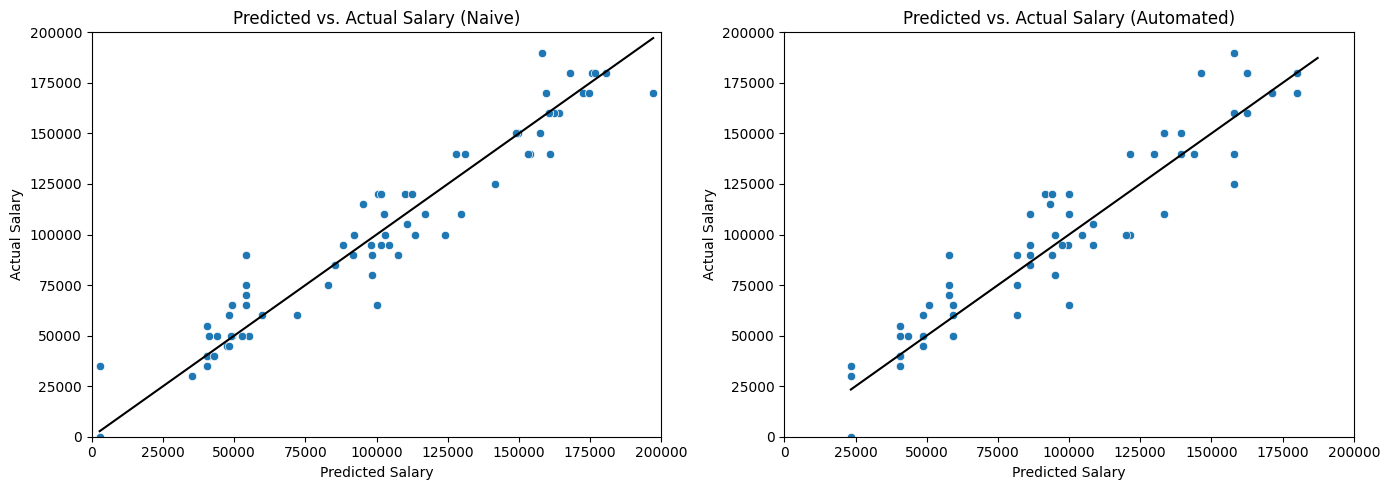

In [218]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First plot (Naive Model)
sns.scatterplot(x=y_pred_naive, y=y_test, ax=axes[0])
axes[0].set_xlabel('Predicted Salary')
axes[0].set_ylabel('Actual Salary')
axes[0].set_ylim(0, 200000)
axes[0].set_xlim(0, 200000)
axes[0].set_title('Predicted vs. Actual Salary (Naive)')
sns.lineplot(x=y_pred_naive, y=y_pred_naive, ax=axes[0], color='black')

# Second plot (Automated Model)
sns.scatterplot(x=y_pred, y=y_test, ax=axes[1])
axes[1].set_xlabel('Predicted Salary')
axes[1].set_ylabel('Actual Salary')
axes[1].set_ylim(0, 200000)
axes[1].set_xlim(0, 200000)
axes[1].set_title('Predicted vs. Actual Salary (Automated)')
sns.lineplot(x=y_pred, y=y_pred, ax=axes[1], color='black')

# Show both plots together
plt.tight_layout()
plt.show()